<a href="https://www.kaggle.com/code/wasswassss/xgboost-on-home-data?scriptVersionId=120225967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Table of Contents

- 1 [Importing data / Specifying features and target](#1)
- 2 [Data pre-processing](#2)
    - 2.1 [Encoding categorical columns](#2.1)
    - 2.2 [Handling missing values](#2.2)
- 3 [Building the model](#3)
    - 3.1 [DMatrix](#3.1)
    - 3.2 [Spliting the data](#3.2)
    - 3.3 [Model setting / parameters](#3.3)
- 4 [Testing model's perf](#4)
    - 4.1 [Computing MAE](#4.1)
    - 4.2 [ Hyperparameters tuning using HYPEROPT](#4.2)
    - 4.3 [K-fold Cross Validation](#4.3)
    - 4.4 [Feature importance](#4.4)

# **1. Importing data / Specifying features and target** <a class="anchor" id="1"></a>

In [1]:
import numpy as np 
import pandas as pd 
#importing the database
data=pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
data2=data.copy()
#droping rows with missing target value
data.dropna(axis=0, subset=['SalePrice'],inplace=True)

#Defining the target
y=data.SalePrice
#Defining the features + Dropping columns with more than 80% of NA Values
data.drop(['SalePrice','Alley','Fence','MiscFeature','PoolQC'],axis=1,inplace=True)

# **2. Data pre-processing** <a class="anchor" id="2"></a>

### **2.1. Encoding categorical columns** <a class="anchor" id="2.1"></a>
We need to verify whether there are any categorical columns in our dataset that require conversion to numerical format.

In [2]:
categorical_columns=[col for col in data.columns
                     if (data[col].dtype=='O')]
categorical_columns

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [3]:
# Before hot encoding
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal


In [4]:
# After applying hot encoding
data=pd.get_dummies(data)
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [5]:
# Checking if there are any missing values
data.isnull().any()
# We can notice that some columns have NA values such as 'LotFrontage'

Id                       False
MSSubClass               False
LotFrontage               True
LotArea                  False
OverallQual              False
                         ...  
SaleCondition_AdjLand    False
SaleCondition_Alloca     False
SaleCondition_Family     False
SaleCondition_Normal     False
SaleCondition_Partial    False
Length: 276, dtype: bool

### **2.2. Handling missing values** <a class="anchor" id="2.2"></a>
Instead of droppign rows or columns with missing values, I chose to perform imputation. The SimpleImputer class, by default, fills in the missing values with the **mean** of the non-missing values in each respective column. 

In [6]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_data = pd.DataFrame(my_imputer.fit_transform(data))

#sets the column names of the imputed_data DataFrame to be the same as the column names of the original data DataFrame
#This is necessary because the fit_transform() method returns an array, which doesn't have column names.
imputed_data.columns=data.columns

In [7]:
# Checking 
imputed_data.isnull().any().any()
# The 'False' returned means that there is no single missing value in our dataset at this point

False

In [8]:
#Since we dropped rows with missing prices, the labels have no NA values
y.isnull().any()

False

# **3. Building the model** <a class="anchor" id="3"></a>

### **3.1 DMatrix** <a class="anchor" id="3.1"></a>
The **DMatrix** object stores the input features in a compressed format that is optimized for efficient computation during training and prediction. 

In [9]:
# import XGBoost
import xgboost as xgb
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=imputed_data,label=y)

### **3.2 Spliting the dataset** <a class="anchor" id="3.2"></a>

In [10]:
from sklearn.model_selection import train_test_split
# We're perforiming the training on 80% of the dataset
X_train, X_valid, y_train, y_valid = train_test_split(imputed_data, y, train_size=0.8, test_size=0.2,random_state=0)

### **3.3 Model settings / hyparameters** <a class="anchor" id="3.3"></a>
The XGBoost model is configured using the following parameters:

- `max_depth`: sets the maximum depth of each tree in the model.
- `learning_rate`: sets the step size of the gradient descent algorithm used to train the model.
- `subsample`: sets the fraction of training data to use for each tree in the model.
- `colsample_bytree`: sets the fraction of features to use for each tree in the model.
- `objective`: sets the loss function to be optimized during model training.
- `n_estimators`: sets the number of trees to build in the model.


In [11]:
from xgboost import XGBRegressor

params = {
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'objective': 'reg:squarederror',
    'n_estimators':1000
}

xgb_clf = XGBRegressor(**params)
xgb_clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# **4. Testing model's performance** <a class="anchor" id="4"></a>

### **4.1 Computing MAE** <a class="anchor" id="4.1"></a>

The mean absolute error (MAE) is a common evaluation metric used in **regression** analysis. It measures the **average absolute difference** between the predicted and actual values of the target variable. In other words, it measures how far off the predictions are on average.

In [12]:
from sklearn.metrics import mean_absolute_error

# Predicted values
y_pred = xgb_clf.predict(X_valid)


print('The model MAE is:'+str(mean_absolute_error(y_valid, y_pred)) )

The model MAE is:15166.699004708904


### **4.2 Hyperparameters tuning using HYPEROPT** <a class="anchor" id="4.2"></a>
HYPERPLOT is a library that helps to determine the best hyperparameters for a model by testing different values for each hyperparameter.

In [13]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space1 = {
    'max_depth': hp.uniform("max_depth",1,18),
    'learning_rate':hp.uniform('learning_rate',0,1),
    'subsample': hp.uniform('subsample',0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
    'objective': 'reg:squarederror',
    'n_estimators': hp.uniform('n_estimators',100,2000)
}

In [14]:
def objective(space1):
    clf = xgb.XGBRegressor(
                    n_estimators=int(space1['n_estimators']), 
                    max_depth=int(space1['max_depth']), 
                    colsample_bytree=space1['colsample_bytree'],
                    subsample=space1['subsample'],
                    objective=space1['objective'],
                    learning_rate=space1['learning_rate'])
    
    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_metric="mae",verbose=False,early_stopping_rounds=10
            )
    
    pred = clf.predict(X_valid)
    mae = mean_absolute_error(y_valid, pred)
    print ("SCORE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [15]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space1,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
28600.885956228594
  1%|          | 1/100 [00:00<00:19,  5.11trial/s, best loss: 28600.885956228594]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21165.89993578767
  2%|▏         | 2/100 [00:04<04:16,  2.62s/trial, best loss: 21165.89993578767] 

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
23054.783711472603
  3%|▎         | 3/100 [00:04<02:34,  1.59s/trial, best loss: 21165.89993578767]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17103.441299229453
  4%|▍         | 4/100 [00:05<02:13,  1.39s/trial, best loss: 17103.441299229453]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16102.480629280823
  5%|▌         | 5/100 [00:08<02:48,  1.77s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22904.412885273974
SCORE:
44796.35798373288
  7%|▋         | 7/100 [00:09<01:28,  1.06trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21380.252461472603
  8%|▊         | 8/100 [00:09<01:10,  1.30trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19951.84480682791
SCORE:
31350.236395012842
 10%|█         | 10/100 [00:10<00:47,  1.90trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16719.074245505137
SCORE:
29795.7063506662
 12%|█▏        | 12/100 [00:11<00:57,  1.52trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
27715.70124879602
 13%|█▎        | 13/100 [00:12<00:46,  1.85trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
23999.838372217466
 14%|█▍        | 14/100 [00:12<00:48,  1.78trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22968.12703339041
 15%|█▌        | 15/100 [00:13<01:00,  1.41trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20846.127086900684
 16%|█▌        | 16/100 [00:14<00:48,  1.73trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21159.026420697774
 17%|█▋        | 17/100 [00:14<00:46,  1.77trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22006.175901648116
SCORE:
42830.14632384418
 19%|█▉        | 19/100 [00:15<00:31,  2.54trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20634.519879066782
 20%|██        | 20/100 [00:15<00:32,  2.44trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17587.853261451197
SCORE:
29012.342438998287
 21%|██        | 21/100 [00:16<00:37,  2.08trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



 22%|██▏       | 22/100 [00:16<00:31,  2.46trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16149.89914651113
 23%|██▎       | 23/100 [00:21<02:20,  1.82s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17274.56295483733
 24%|██▍       | 24/100 [00:22<02:00,  1.59s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21470.480856699487
 25%|██▌       | 25/100 [00:22<01:29,  1.20s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18669.213733411816
 26%|██▌       | 26/100 [00:23<01:18,  1.06s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16504.53389875856
 27%|██▋       | 27/100 [00:24<01:23,  1.15s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18482.754575128423
 28%|██▊       | 28/100 [00:35<04:41,  3.92s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20673.88603649401
SCORE:
33011.21100438784
 30%|███       | 30/100 [00:35<02:23,  2.06s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18054.92746682363
 31%|███       | 31/100 [00:36<01:50,  1.60s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20841.854345034248
 32%|███▏      | 32/100 [00:49<05:49,  5.13s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20804.81232609161
 33%|███▎      | 33/100 [00:50<04:07,  3.70s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17163.908617829624
 34%|███▍      | 34/100 [00:51<03:07,  2.84s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16748.879106913526
 35%|███▌      | 35/100 [00:51<02:24,  2.23s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20603.083489404966
 36%|███▌      | 36/100 [00:52<01:44,  1.64s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
100788.18304526969
 37%|███▋      | 37/100 [00:55<02:19,  2.22s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
25054.964870505137
 38%|███▊      | 38/100 [00:56<01:47,  1.73s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16564.110391695205
 39%|███▉      | 39/100 [00:57<01:44,  1.72s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18342.687352846748
SCORE:
24243.39916657748
 41%|████      | 41/100 [00:59<01:07,  1.15s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
36107.682985070634
 42%|████▏     | 42/100 [00:59<00:49,  1.18trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19365.80086151541
 43%|████▎     | 43/100 [00:59<00:41,  1.36trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18738.369782748287
 44%|████▍     | 44/100 [01:00<00:36,  1.54trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16511.367976776542
 45%|████▌     | 45/100 [01:04<01:40,  1.83s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22093.138457833906
SCORE:
23314.52216663099
 47%|████▋     | 47/100 [01:05<00:56,  1.06s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
32228.31494140625
 48%|████▊     | 48/100 [01:05<00:41,  1.25trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
27871.397113120718
 49%|████▉     | 49/100 [01:06<00:32,  1.56trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20205.541136023116
 50%|█████     | 50/100 [01:06<00:28,  1.76trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19589.33674015411
 51%|█████     | 51/100 [01:06<00:25,  1.95trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22348.594699807363
 52%|█████▏    | 52/100 [01:07<00:21,  2.24trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17651.507143621577
 53%|█████▎    | 53/100 [01:08<00:34,  1.35trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20365.71076359161
 54%|█████▍    | 54/100 [01:09<00:29,  1.54trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17283.80070098459
 55%|█████▌    | 55/100 [01:12<01:04,  1.42s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18037.540453767124
 56%|█████▌    | 56/100 [01:12<00:50,  1.15s/trial, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22402.053657427226
 57%|█████▋    | 57/100 [01:13<00:38,  1.11trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
18808.589629708906
 58%|█████▊    | 58/100 [01:13<00:34,  1.21trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
45858.13877889555
 59%|█████▉    | 59/100 [01:14<00:31,  1.30trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
24857.1162109375
 60%|██████    | 60/100 [01:14<00:24,  1.62trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19932.269651648116
 61%|██████    | 61/100 [01:15<00:23,  1.66trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20062.356124250855
 62%|██████▏   | 62/100 [01:16<00:25,  1.46trial/s, best loss: 16102.480629280823]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16078.237772902397
 63%|██████▎   | 63/100 [01:17<00:33,  1.10trial/s, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21028.82803135702
 64%|██████▍   | 64/100 [01:18<00:28,  1.28trial/s, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17439.217666416953
 65%|██████▌   | 65/100 [01:18<00:25,  1.35trial/s, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17988.177413313355
 66%|██████▌   | 66/100 [01:20<00:35,  1.03s/trial, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17614.87071917808
 67%|██████▋   | 67/100 [01:21<00:32,  1.03trial/s, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17671.25540453767
 68%|██████▊   | 68/100 [01:21<00:25,  1.24trial/s, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17909.36995665668
 69%|██████▉   | 69/100 [01:22<00:22,  1.38trial/s, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16917.470569349316
 70%|███████   | 70/100 [01:26<00:53,  1.79s/trial, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16322.669252996575
 71%|███████   | 71/100 [01:27<00:45,  1.55s/trial, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19962.85094713185
 72%|███████▏  | 72/100 [01:28<00:39,  1.43s/trial, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16935.39693921233
 73%|███████▎  | 73/100 [01:30<00:39,  1.47s/trial, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16427.752541738013
 74%|███████▍  | 74/100 [01:34<01:02,  2.41s/trial, best loss: 16078.237772902397]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15803.171286386987
 75%|███████▌  | 75/100 [01:36<00:58,  2.35s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19941.347856913526
 76%|███████▌  | 76/100 [01:37<00:41,  1.74s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15953.80096853596
 77%|███████▋  | 77/100 [01:40<00:49,  2.15s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19386.24194670377
 78%|███████▊  | 78/100 [01:41<00:37,  1.71s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
15857.225813356165
 79%|███████▉  | 79/100 [01:43<00:41,  1.97s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17781.625775898974
 80%|████████  | 80/100 [01:45<00:39,  1.97s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17759.975719713184
 81%|████████  | 81/100 [01:46<00:29,  1.55s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19781.91767444349
SCORE:
33804.985175981914
 83%|████████▎ | 83/100 [01:47<00:16,  1.01trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
33373.13487264555
 84%|████████▍ | 84/100 [01:47<00:11,  1.34trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
25935.78657427226
 85%|████████▌ | 85/100 [01:47<00:09,  1.56trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22246.618672410103
SCORE:
29184.443546660958
 87%|████████▋ | 87/100 [01:48<00:06,  2.14trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16257.168196168665
 88%|████████▊ | 88/100 [01:49<00:07,  1.53trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19154.92978114298
 89%|████████▉ | 89/100 [01:49<00:06,  1.65trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19145.66053082192
 90%|█████████ | 90/100 [01:51<00:09,  1.03trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
22785.559102097603
 91%|█████████ | 91/100 [01:52<00:08,  1.06trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
17079.58585723459
 92%|█████████▏| 92/100 [01:53<00:07,  1.11trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16749.774721746577
 93%|█████████▎| 93/100 [01:54<00:07,  1.08s/trial, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
21735.080934289384
SCORE:
29787.641815603594
 95%|█████████▌| 95/100 [01:55<00:03,  1.53trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
33372.121602097606
 96%|█████████▌| 96/100 [01:55<00:02,  1.91trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
20186.179299550513
 97%|█████████▋| 97/100 [01:56<00:01,  1.79trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
19122.212917380137
 98%|█████████▊| 98/100 [01:57<00:01,  1.39trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
16476.459171660958
 99%|█████████▉| 99/100 [01:58<00:00,  1.22trial/s, best loss: 15803.171286386987]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,



SCORE:
23306.682202482876
100%|██████████| 100/100 [01:58<00:00,  1.19s/trial, best loss: 15803.171286386987]


**Observation** The best score differs from an execution to an other but in general there's so big difference from initial parameters (I am going to try other parameters for the hyperopt and share them If I ever get better results)

### **4.3 K-fold Cross Validation** <a class="anchor" id="4.2"></a>
K-fold cross-validation is a technique used to assess the performance of the model. It involves **partitioning** the original dataset into k equally sized subsets, or "folds". One of these folds is held out as a validation set, while the remaining k-1 folds are used for training the model. By doing this we can chose see which partitioning of the dataset gives the best results

In [16]:
from xgboost import cv

# XGB Model parameters
params = {
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'objective': 'reg:squarederror',
    'n_estimators':1000
}
xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=50,
            early_stopping_rounds=10, metrics="mae", as_pandas=True)

[22:45:48] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:45:48] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:45:48] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [17]:
xgb_cv

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,175641.222911,1035.126602,175651.360989,2096.245640
1,170502.680589,962.774100,170488.403018,2111.459691
2,165545.956200,888.993458,165514.317567,2132.877549
3,160670.480392,836.032535,160594.270420,2128.164149
4,155953.942187,784.206618,155878.774085,2111.253840
5,151394.221332,755.757634,151294.218397,2083.155046
6,146988.224124,707.054467,146882.233528,2052.925172
7,142718.727440,705.803816,142592.931122,1992.612201
8,138594.580912,681.710210,138470.788974,1943.498986
9,134505.927490,640.356872,134391.000602,1902.186687


### **4.4 Feature importance** <a class="anchor" id="4.3"></a>
XGBoost provides a way to examine the importance of each feature in the original dataset within the model.

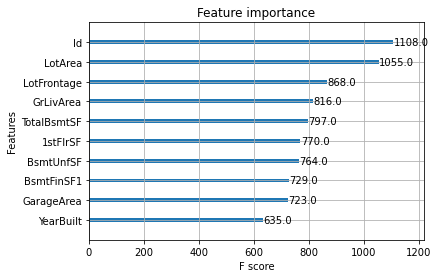

<Figure size 1152x720 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
xgb.plot_importance(xgb_clf, max_num_features=10)
plt.figure(figsize=(16, 10))
plt.show()

**Observation :** 
Here's what we've noticed: the features that seem to matter the most are the ones related to how much space there is, especially LotArea. That's the one with the biggest impact on the sale price, and you can see that clearly in the regression plot below because it has a strong positive relationship. 

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

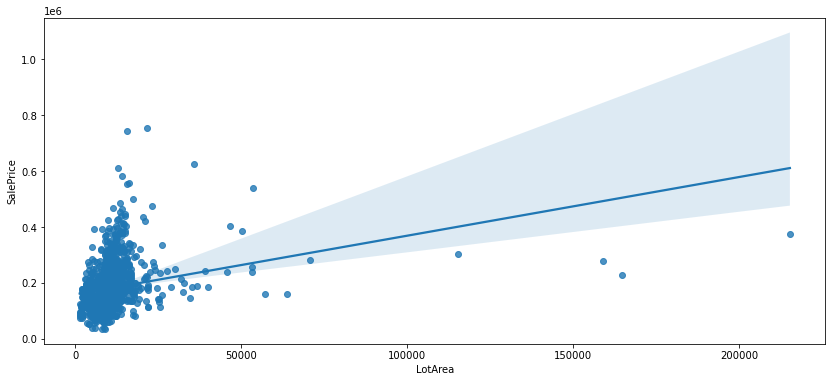

In [19]:
import seaborn as sns
plt.figure(figsize=(14,6))
sns.regplot(data=data2,x='LotArea',y='SalePrice')